In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from glob import glob
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = glob('/content/drive/MyDrive/Fingerprint-Reconstruction/train-data/*')
len(data)

6000

In [32]:
images = []
def read_images(data):
  for i in range(len(data)):
    img = Image.open(data[i])
    img = img.convert('L')
    img = img.resize((120,120))
    img = np.array(img)
    images.append(img)
  return images

In [33]:
images = read_images(data)
print(images[0])

[[160 161 162 ...   0   0   0]
 [162 128 108 ...   0   0   0]
 [162 112 151 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [34]:
print(images[0].shape)

(120, 120)


In [35]:
# converting to image array
img_arr = np.asarray(images)
img_arr = img_arr.astype('float32')

# shape of image array
print(img_arr.shape)

(6000, 120, 120)


In [36]:
print("Dataset (images) shape: {shape}".format(shape=img_arr.shape))

Dataset (images) shape: (6000, 120, 120)


<Figure size 360x360 with 0 Axes>

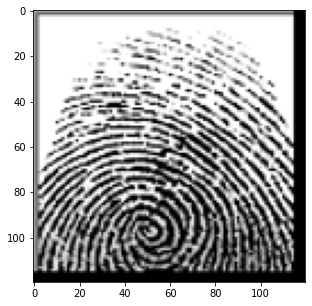

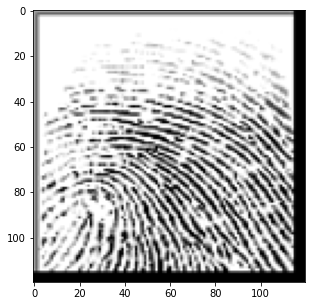

In [37]:
plt.figure(figsize=[5,5])

# Display the first 2 image in training data
for i in range(2):
    plt.figure(figsize=[5, 5])
    curr_img = np.reshape(img_arr[i], (120,120))
    plt.imshow(curr_img, cmap='gray')
    plt.show()

In [38]:
# reshaping images into (120, 120, 1) matrices
img_arr = img_arr.reshape(-1 , 120 ,120 , 1)

# Shape of image matrices
print('Converted Images Shape :' , img_arr.shape )

Converted Images Shape : (6000, 120, 120, 1)


In [39]:
# Verify that the object type is float32
print(img_arr.dtype)

float32


In [40]:
# Rescaling the image matrix

max_pixel_value = np.max(img_arr) # ideally should be 255
print("Maximum Pixel Value: ", max_pixel_value)

img_arr = img_arr / max_pixel_value

# Verify whether the new max and min and 1 and 0 respectively
print("New Max and Min:", np.max(img_arr), np.min(img_arr))

Maximum Pixel Value:  255.0
New Max and Min: 1.0 0.0


In [41]:
'''Performing Train-Test split using 80% of the data to train and 20% of the data to validate the model '''
from sklearn.model_selection import train_test_split as tts

'''
We do not have X and y training labels here unlike non-image datasets. As a result, our images act as
training examples as well as ground truth examples for our model. Hence, we pass img_arr twice as arguments.
'''
X_train, X_test, y_train, y_test = tts(img_arr, img_arr, test_size = 0.2, random_state=0)

In [42]:
''' train data and test data length '''
len(X_train), len(X_test)

(4800, 1200)

In [43]:
''' train labels and test labels length '''
len(y_train), len(y_test)

(4800, 1200)

In [54]:
''' initializing some parameters '''
batch_size = 64
epochs = 200
channel = 1
x, y = 120, 120
input_img = Input(shape = (x, y, channel))

In [55]:
'''Encoder Function'''

def autoencoder(input_img):
  ''' encoder'''
  '''Image gets downsampled 2 times'''
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
  encoder_last = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 

  ''' decoder '''
  '''Image gets upsampled 2 times'''
  conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder_last) 
  up1 = UpSampling2D((2,2))(conv4) 
  conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
  up2 = UpSampling2D((2,2))(conv5) 
  dec = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

  return dec

In [56]:
# Model
model = Model(input_img, autoencoder(input_img))

In [57]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [58]:
# Model Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 120, 120, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 128)       7385

In [59]:
# Training the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/200
75/75 [==============================] - 8s 101ms/step - loss: 0.0626 - mse: 0.0626 - mae: 0.1884 - val_loss: 0.0469 - val_mse: 0.0469 - val_mae: 0.1513
Epoch 2/200
75/75 [==============================] - 8s 100ms/step - loss: 0.0457 - mse: 0.0457 - mae: 0.1479 - val_loss: 0.0440 - val_mse: 0.0440 - val_mae: 0.1440
Epoch 3/200
75/75 [==============================] - 7s 97ms/step - loss: 0.0432 - mse: 0.0432 - mae: 0.1415 - val_loss: 0.0427 - val_mse: 0.0427 - val_mae: 0.1397
Epoch 4/200
75/75 [==============================] - 7s 99ms/step - loss: 0.0406 - mse: 0.0406 - mae: 0.1357 - val_loss: 0.0380 - val_mse: 0.0380 - val_mae: 0.1302
Epoch 5/200
75/75 [==============================] - 7s 98ms/step - loss: 0.0365 - mse: 0.0365 - mae: 0.1267 - val_loss: 0.0335 - val_mse: 0.0335 - val_mae: 0.1202
Epoch 6/200
75/75 [==============================] - 7s 98ms/step - loss: 0.0324 - mse: 0.0324 - mae: 0.1175 - val_loss: 0.0300 - val_mse: 0.0300 - val_mae: 0.1116
Epoch 7/200
75

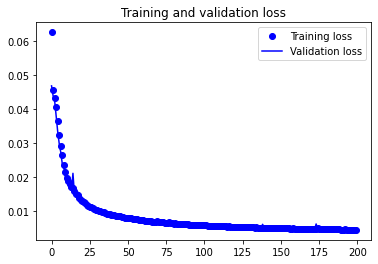

In [60]:
''' validation and training loss graph'''

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(200)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [61]:
''' prediction '''
y_pred = model.predict(X_test)

Test Images


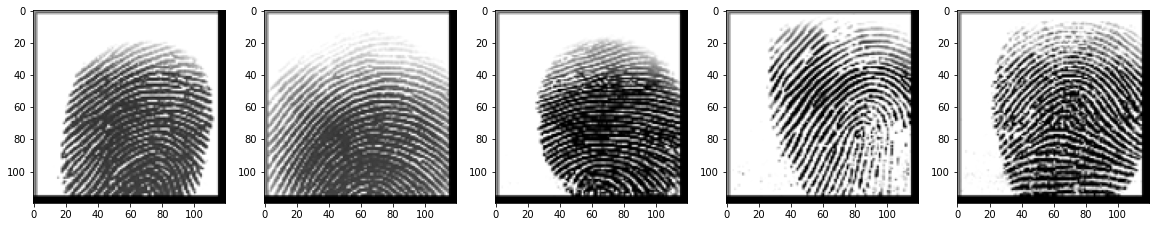

Reconstruction of Test Images


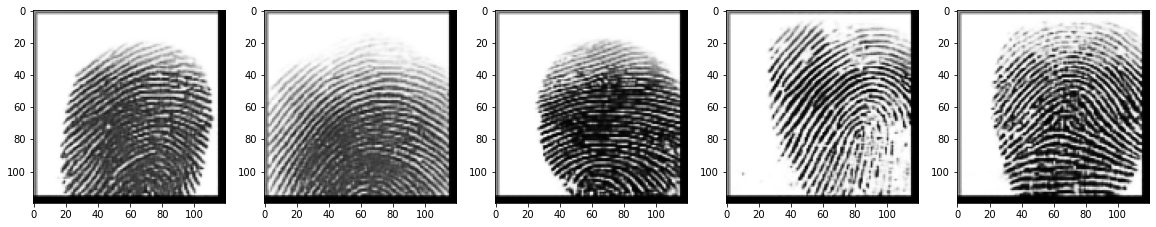

In [62]:
''' visualization '''

plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_test[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(y_pred[i, ..., 0], cmap='gray')  
    
plt.show()

In [65]:
# pickle model
import pickle

with open('fingerprint_reconstruction_model.pickle', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://d2da4b04-5ca5-48a4-aa8d-34948a260637/assets
